# Install required packages

In [ ]:
pip install -r requirements.txt

# Import required packages

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, classification_report,
    roc_auc_score
)
from sklearn.model_selection import (
    train_test_split, GridSearchCV, cross_val_score, KFold
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif, RFE, RFECV
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression, LassoCV, Lars
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    AdaBoostClassifier, HistGradientBoostingClassifier
)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

script_dir = os.path.abspath("../scripts")
import sys
sys.path.append(script_dir)
from data_preprocessing import data_preprocessing
from feature_eng_hyp_device_activity import generateDeviceActivityFeatures
from feature_eng_account_kmeans import get_account_related_and_kmeans_feature as generateKmeansFeatures
from feature_eng_hyp_distinct_email_same_DOB import bin_distinct_emails_same_DOB as generateEmailsDobBins
from feature_eng_hyp_name_email_similarity import bin_name_email_similarity as generateNameEmailSimilarityBins
from feature_eng_hyp_session_length import bin_session_length as generateSessionLengthBins

import warnings
# Suppress warnings
warnings.filterwarnings("ignore")

## Import dataset and data preprocessing

This section includes:
+ Downloading data from kaggle (_Note: In order to download dataset from Kaggle, you must first setup KaggleAPI._)
+ Data preprocessing
    + Removal of Irrelevant Variables
    + Handling of Missing Variables
    + Undersampling of Imbalanced Dataset

For in-depth analysis on data preprocessing, please refer to [Data Preprocessing Notebook](./1.0-data-preprocessing.ipynb).

### Setting up KaggleAPI

In order to use the Kaggle’s public API, you must first authenticate using an API token.

On Kaggle, go to 'Your Profile' > 'Settings' > 'Account' tab > 'API' section and select 'Create New Token'. This will trigger the download of `kaggle.json`, a file containing your API credentials.

If you are using the Kaggle CLI tool, the tool will look for this token at `~/.kaggle/kaggle.json` on Linux, OSX, and other UNIX-based operating systems, and at `C:\Users\<Windows-username>\.kaggle\kaggle.json` on Windows. If the token is not there, an error will be raised. Hence, once you’ve downloaded the token, you should move it from your Downloads folder to this folder.

If you are using the Kaggle API directly, where you keep the token doesn’t matter, so long as you are able to provide your credentials at runtime.

### Running import and preprocessing script

In [25]:
sys.path.append('../scripts')
import data_preprocessing

data_preprocessing.data_preprocessing()

Base.csv found. Skipping the download and extraction process...
Data Preprocessing...
Data Preprocessing completed successfully. Data saved to 'data/processed/undersampled_data.csv'.
Splitting the dataset into train-test subset...
Train-test split completed successfully. Data saved to 'data/processed/X_train.csv', 'data/processed/X_test.csv', 'data/processed/y_train.csv', and 'data/processed/y_test.csv'.


In [8]:
# Read the CSV file into a DataFrame
X_test = pd.read_csv('../data/processed/X_test.csv')
y_test = pd.read_csv('../data/processed/y_test.csv')

## Feature Enginnering

New features are engineered and introduced into the dataset:

Hypothesis - **Device Activity** ([Hypothesis - Device Activity Notebook](./3.0-hypothesis-device-activity.ipynb))
+ `FE_01_device_os_emails_prob`
+ `FE_02_keep_alive_device_emails_prob`
+ `FE_03_source_foreign_request_prob`
+ `FE_04_device_os_foreign_request_prob`
+ `FE_05_device_os_prob`

Hypothesis - **Distinct Email Same DOB** ([Hypothesis - Distinct Email Same DOB Notebook](./3.1-hypothesis-name-email-similarity.ipynb))
+ `emails_bin`
+ `name_email_similarity_bins`

Hypothesis - **Session Length** ([Hypothesis - Session Length Notebook](./3.2-hypothesis-session-length.ipynb))
+ `session_length_bins`

Hypothesis - **K Means** ([Hypothesis - K Means Notebook](./3.3-hypothesis-clustering.ipynb))
+ `kmeans_prob`

Hypothesis - **Income Credit Limit Ratio** ([Hypothesis - K Means Notebook](./3.4-hypothesis-income-credit-limit-ratio.ipynb))
+ `income_credit_limit_ratio`

Hypothesis - **Bank Integration** ([Hypothesis - K Means Notebook](./3.5-hypothesis-bank-integration.ipynb))
+ `have_prev_address`
+ `have_initial_bal`
+ `bank_integration`


### Define feature engineering methods

In [9]:
feature_engineering_methods = [
    generateDeviceActivityFeatures,
    generateKmeansFeatures,
    generateEmailsDobBins,
    generateNameEmailSimilarityBins,
    generateSessionLengthBins
]

# Fraud Detection Models

## Helper Functions

### One-hot encoding for categorical variable in test dataset

In [10]:
### One-hot encoding of categorical features
# Split categorical and non-categorical variables
def clean_df_dtype(df):
    df = pd.DataFrame(df)
    df_label = df['fraud_bool']
    df_non_cat = df.drop(columns=['fraud_bool']).select_dtypes(exclude=['object','category'])
    df_cat =df.drop(columns=['fraud_bool']).select_dtypes(include=['object','category']) 
    # Perform one-hot encoding
    one_hot_encoded = pd.get_dummies(df_cat)
    # Concatenate the one-hot encoded columns with the original DataFrame
    df_encoded = pd.concat([df_non_cat, one_hot_encoded], axis=1)
    # df_encoded.info()
    X =df_encoded 
    y =df_label 
    return X,y

### Run LARS to standardise and select features 

In [11]:
def standardize_and_select_features(df_train, df_test):
    X_train, y_train = clean_df_dtype(df_train)
    X_test, y_test = clean_df_dtype(df_test)

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Apply LARS feature selection
    lars_model = Lars()
    lars_model.fit(X_train_scaled, y_train)
    selected_features = lars_model.coef_ != 0
    
    # Select relevant features
    X_train_selected = X_train_scaled[:, selected_features]
    X_test_selected = X_test_scaled[:, selected_features]
    
    # Print features removed and features kept
    removed_features = X_train.columns[~selected_features]
    kept_features = X_train.columns[selected_features]
    print("Features Removed:", removed_features)
    print("Features Kept:", kept_features)
    
    # Print the shapes of selected features
    print("Shape of X_train_selected:", X_train_selected.shape)
    print("Shape of X_test_selected:", X_test_selected.shape)
    
    return X_train_selected, X_test_selected, y_train, y_test, removed_features,kept_features
    

### Train and Evaluate Models

In [12]:
def train_and_evaluate_model(model_name, model, X_train, y_train, X_test, y_test):
    model_directory = '../models/'
    os.makedirs(model_directory, exist_ok=True)  # Create the directory if it doesn't exist
    
    # Define the file path for saving/loading the model
    # model_name = type(model).__name__
    model_path = os.path.join(model_directory, f"{model_name.lower()}.pkl")
    
    # Check if the model file exists
    if os.path.exists(model_path):
        # Load the model from the file
        with open(model_path, 'rb') as file:
            model = pickle.load(file)
    else:
        # Initialize the KFold cross-validation iterator
        kf = KFold(n_splits=5, shuffle=True, random_state=42)

        # Perform k-fold cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='f1')
        print("Cross-validation scores:", cv_scores)
        print("Mean CV accuracy:", np.mean(cv_scores))

        # Train the model on the entire training dataset
        model.fit(X_train, y_train)

        # Save the trained model
        with open(model_path, 'wb') as file:
            pickle.dump(model, file)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Compute evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred) 
    # Compute ROC AUC
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    
    # Print evaluation metrics
    print("Model:", model_name)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    
    # Return the fitted model and evaluation metrics
    return model, fpr, tpr, thresholds, roc_auc

## Baseline Model

For our Baseline model, we employed a logistic regression approach to train on the entire dataset, with categorical variables one-hot encoded. Additionally, we implemented K-fold cross-validation during both model training and evaluation stages.

For more details on model training, refer to [Baseline Model Notebook](./4.0-baseline-model.ipynb).

In [13]:
evaluation_metrics = {}

# Load X_train and y_train data from the processed CSV files
X_train = pd.read_csv('../data/processed/X_train.csv')
y_train = pd.read_csv('../data/processed/y_train.csv')
X_test = pd.read_csv('../data/processed/X_test.csv')
y_test = pd.read_csv('../data/processed/y_test.csv')

df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

X_train,y_train = clean_df_dtype(df_train)
X_test,y_test = clean_df_dtype(df_test)

#Baseline Model
with open('../models/baseline_model.pkl', 'rb') as file:
    baseline_model = pickle.load(file)
    
y_pred = baseline_model.predict(X_test)

# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
baseline_conf_matrix = confusion_matrix(y_test, y_pred)

# Compute ROC AUC
baseline_roc_auc = roc_auc_score(y_test, baseline_model.predict_proba(X_test)[:,1])
fpr_baseline, tpr_baseline, _ = roc_curve(y_test, baseline_model.predict_proba(X_test)[:,1])

# Store evaluation metrics for the baseline model
evaluation_metrics['Baseline'] = {
    'Accuracy': accuracy,
    'Precision': precision ,
    'Recall': recall ,
    'F1 Score': f1 ,
    'ROC AUC': baseline_roc_auc,
    'fpr': fpr_baseline,
    'tpr' : tpr_baseline,
    'Confusion Matrix' : baseline_conf_matrix
}

## Challenger Model

For more details on:
+ model analysis and selection
+ feature set analysis selection
+ model training

refer to [Challenger Model Notebook](./4.1-challenger-model.ipynb).


### One-hot enconding for categorical variables

In [14]:
### One-hot encoding of categorical features
# Split categorical and non-categorical variables
cm_test_cat = X_test_FE.select_dtypes(include=['object', 'category'])
cm_test_non_cat = X_test_FE.select_dtypes(exclude=['object', 'category'])

# Perform one-hot encoding on categorical variables
cm_test_one_hot_encoded = pd.get_dummies(cm_test_cat)

# Combine the non-categorical and one-hot encoded categorical variables
cm_X_test = pd.concat([cm_test_non_cat, cm_test_one_hot_encoded], axis=1)

cm_X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13194 entries, 1054 to 12177
Data columns (total 76 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   income                               13194 non-null  float64
 1   name_email_similarity                13194 non-null  float64
 2   prev_address_months_count            13194 non-null  int64  
 3   current_address_months_count         13194 non-null  int64  
 4   customer_age                         13194 non-null  int64  
 5   days_since_request                   13194 non-null  float64
 6   intended_balcon_amount               13194 non-null  float64
 7   zip_count_4w                         13194 non-null  int64  
 8   velocity_6h                          13194 non-null  float64
 9   velocity_24h                         13194 non-null  float64
 10  velocity_4w                          13194 non-null  float64
 11  bank_branch_count_8w     

## Challenger Model 1

Extreme Gradient Boosting (XGBoost) with feature selection using LARS:

Selected features:
+ `income`
+ `name_email_similarity`
+ `prev_address_months_count`
+ `current_address_months_count`
+ `customer_age`
+ `days_since_request`
+ `intended_balcon_amount`
+ `zip_count_4w`
+ `velocity_6h`, `velocity_24h`, `velocity_4w`
+ `bank_branch_count_8w`
+ `date_of_birth_distinct_emails_4w`
+ `credit_risk_score`
+ `email_is_free`
+ `phone_home_valid`
+ `phone_mobile_valid`
+ `bank_months_count`
+ `has_other_cards`
+ `proposed_credit_limit`
+ `foreign_request`
+ `session_length_in_minutes`
+ `keep_alive_session`
+ `device_distinct_emails_8w`
+ `month`
+ `payment_type_AA`, `payment_type_AC`, `payment_type_AD`, `payment_type_AE`,
+ `employment_status_CA`, `employment_status_CB`, `employment_status_CC`, `employment_status_CE`, `employment_status_CF`, `employment_status_CG`,
+ `housing_status_BA`, `housing_status_BB`, `housing_status_BD`, `housing_status_BE`, `housing_status_BF`, `housing_status_BG`,
+ `source_TELEAPP`
+ `device_os_linux`, `device_os_macintosh`, `device_os_windows`, `device_os_x11`
+ `emails_bin_0-10`, `emails_bin_20-30`, `emails_bin_>30`

### Extract features for challenger model 1

In [35]:
# Load X_train and y_train data from the processed CSV files
X_train = pd.read_csv('../data/processed/X_train.csv')
y_train = pd.read_csv('../data/processed/y_train.csv')
X_test = pd.read_csv('../data/processed/X_test.csv')
y_test = pd.read_csv('../data/processed/y_test.csv')

df_train_c1 = pd.concat([X_train, y_train], axis=1)
df_test_c1 = pd.concat([X_test, y_test], axis=1)

generateEmailsDobBins(df_train_c1)
generateEmailsDobBins(df_test_c1)

X_train_c1, X_test_c1, y_train_c1, y_test_c1 , removed_features,kept_features = standardize_and_select_features(df_train_c1, df_test_c1)
challenger_model_1 = XGBClassifier(random_state=42)
# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(challenger_model_1, X_train_c1, y_train_c1, cv=kf, scoring='recall')
print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", np.mean(cv_scores))

# Train the model on the entire training dataset
challenger_model_1.fit(X_train_c1, y_train_c1)

# Save the trained model
with open('../models/challenger_model_1.pkl', 'wb') as file:
    pickle.dump(challenger_model_1, file)

# Make predictions on the test set
y_pred = challenger_model_1.predict(X_test_c1)

# Compute evaluation metrics
accuracy = accuracy_score(y_test_c1, y_pred)
precision = precision_score(y_test_c1, y_pred)
recall = recall_score(y_test_c1, y_pred)
f1 = f1_score(y_test_c1, y_pred) 
c1_conf_matrix = confusion_matrix(y_test_c1, y_pred)

# Compute ROC AUC
roc_auc = roc_auc_score(y_test_c1, challenger_model_1.predict_proba(X_test_c1)[:,1])
fpr, tpr, thresholds = roc_curve(y_test_c1, challenger_model_1.predict_proba(X_test_c1)[:,1])

# Print evaluation metrics
print("Model:", 'Challenger Model 1')
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

evaluation_metrics['Challenger Model 1'] = {
    'Accuracy': accuracy,
    'Precision': precision ,
    'Recall': recall ,
    'F1 Score': f1 ,
    'ROC AUC': roc_auc,
    'fpr': fpr,
    'tpr' : tpr,
    'Confusion Matrix' : c1_conf_matrix }



Features Removed: Index(['payment_type_AB', 'employment_status_CD', 'housing_status_BC',
       'source_INTERNET', 'device_os_other', 'emails_bin_10-20'],
      dtype='object')
Features Kept: Index(['income', 'name_email_similarity', 'prev_address_months_count',
       'current_address_months_count', 'customer_age', 'days_since_request',
       'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'credit_risk_score',
       'email_is_free', 'phone_home_valid', 'phone_mobile_valid',
       'bank_months_count', 'has_other_cards', 'proposed_credit_limit',
       'foreign_request', 'session_length_in_minutes', 'keep_alive_session',
       'device_distinct_emails_8w', 'month', 'payment_type_AA',
       'payment_type_AC', 'payment_type_AD', 'payment_type_AE',
       'employment_status_CA', 'employment_status_CB', 'employment_status_CC',
       'employment_status_CE', 'employment_statu

## Challenger Model 2

Adaptive Boosting (ADA Boost) with feature selection

Selected features:
+ `income`
+ `name_email_similarity`
+ `prev_address_months_count`
+ `current_address_months_count`
+ `customer_age`
+ `days_since_request`
+ `intended_balcon_amount`
+ `zip_count_4w`
+ `velocity_24h`, `velocity_4w`
+ `bank_branch_count_8w`
+ `date_of_birth_distinct_emails_4w`
+ `credit_risk_score`
+ `email_is_free`
+ `phone_home_valid`
+ `phone_mobile_valid`
+ `bank_months_count`
+ `has_other_cards`
+ `proposed_credit_limit`
+ `foreign_request`
+ `session_length_in_minutes`
+ `keep_alive_session`
+ `device_distinct_emails_8w`
+ `month`
+ `have_prev_address`
+ `bank_integration`
+ `income_credit_limit_ratio`
+ `payment_type_AC`
+ `employment_status_CA`, `employment_status_CB`, `employment_status_CC`
+ `housing_status_BA`, `housing_status_BE`
+ `device_os_linux`, `device_os_macintosh`, `device_os_windows`

### Extract features for challenger model 1

In [16]:
X_train_fe = pd.read_csv('../data/processed/X_train.csv')
y_train_fe = pd.read_csv('../data/processed/y_train.csv')
X_test_fe = pd.read_csv('../data/processed/X_test.csv')
y_test_fe = pd.read_csv('../data/processed/y_test.csv')
df_train_c2 = pd.concat([X_train_fe, y_train_fe], axis=1)
df_test_c2 = pd.concat([X_test_fe, y_test_fe], axis=1)

for feature in feature_engineering_methods:
    feature(df_train_c2)
    feature(df_test_c2)
    
X_train_c2,y_train_c2 = clean_df_dtype(df_train_c2)
X_test_c2,y_test_c2 = clean_df_dtype(df_test_c2)

challenger_model_2_data_cols = ['income', 'name_email_similarity', 'prev_address_months_count',
       'current_address_months_count', 'customer_age', 'days_since_request',
       'intended_balcon_amount', 'zip_count_4w', 'velocity_24h', 'velocity_4w',
       'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w',
       'credit_risk_score', 'email_is_free', 'phone_home_valid',
       'bank_months_count', 'has_other_cards', 'proposed_credit_limit',
       'foreign_request', 'session_length_in_minutes', 'keep_alive_session',
       'device_distinct_emails_8w', 'month', 'have_prev_address',
       'bank_integration', 'income_credit_limit_ratio', 'payment_type_AC',
       'employment_status_CA', 'employment_status_CB', 'employment_status_CC',
       'housing_status_BA', 'housing_status_BE', 'device_os_linux',
       'device_os_macintosh', 'device_os_windows']

In [17]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

with open('../models/challenger_model_2.pkl', 'rb') as file:
    challenger_model_2 = pickle.load(file)

# Select relevant columns for validation
X_test_c2 = X_test_c2[challenger_model_2_data_cols]
X_train_c2 =X_train_c2[challenger_model_2_data_cols] 
# challenger_model_2 = AdaBoostClassifier(random_state=24)
challenger_model_2, fpr, tpr, thresholds, roc_auc = train_and_evaluate_model('challenger_model_2', challenger_model_2, X_train_c2, y_train_c2, X_test_c2, y_test_c2)

y_pred_c2 = challenger_model_2.predict(X_test_c2)
# Calculate evaluation metrics for Challenger Model 2
accuracy = accuracy_score(y_test_c2, y_pred_c2)
precision = precision_score(y_test_c2, y_pred_c2)
recall = recall_score(y_test_c2, y_pred_c2)
f1 = f1_score(y_test_c2, y_pred_c2)
c2_conf_matrix = confusion_matrix(y_test_c2, y_pred_c2)

# Print evaluation metrics
print("Model: Challenger Model 2")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC:", roc_auc)

# Store evaluation metrics in the dictionary
evaluation_metrics['Challenger Model 2'] = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'ROC AUC': roc_auc,
    'fpr': fpr,
    'tpr': tpr,
    'Confusion Matrix' : c2_conf_matrix 
}

Model: challenger_model_2
Accuracy: 0.881158102167652
Precision: 0.6946222791293214
Recall: 0.49862132352941174
F1 Score: 0.5805243445692884
Model: Challenger Model 2
Accuracy: 0.881158102167652
Precision: 0.6946222791293214
Recall: 0.49862132352941174
F1 Score: 0.5805243445692884
ROC AUC: 0.896764289618325


## Model Ensemble

In [18]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
# Obtain predictions from both models on their respective validation or test datasets
y_pred_c1 = challenger_model_1.predict_proba(X_test_c1)[:,1]
y_pred_c2 = challenger_model_2.predict_proba(X_test_c2)[:,1]


# Combine predictions using a voting scheme
ensemble_predictions =  0.75*(y_pred_c1 + y_pred_c2) # Unweighted average

# Round all values of 0.5 to 1
# ensemble_predictions = np.where(ensemble_predictions == 0.5, 1, ensemble_predictions)
ensemble_predictions = np.round(ensemble_predictions)
# Evaluate the performance of the ensemble model
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
ensemble_precision = precision_score(y_test, ensemble_predictions)
ensemble_recall = recall_score(y_test, ensemble_predictions)
ensemble_f1 = f1_score(y_test, ensemble_predictions)
ensemble_roc_auc = roc_auc_score(y_test, ensemble_predictions)

# Calculate ROC curve for the ensemble model
fpr_ensemble, tpr_ensemble, _ = roc_curve(y_test, ensemble_predictions)

ensemble_conf_matrix = confusion_matrix(y_test, ensemble_predictions)

# Store evaluation metrics for Challenger Model 2
evaluation_metrics['Ensemble'] = {
    'Accuracy': ensemble_accuracy,
    'Precision': ensemble_precision,
    'Recall': ensemble_recall,
    'F1 Score': ensemble_f1,
    'ROC AUC': ensemble_roc_auc,
    'fpr': fpr_ensemble,
    'tpr':tpr_ensemble ,
    'Confusion Matrix' : ensemble_conf_matrix 
}


# Results

## Evaluation Metrics

(accuracy, precision, recall, F1 score)

In [25]:
# Convert to DataFrame
metrics_df = pd.DataFrame(evaluation_metrics).T

# Drop the 'Confusion Matrix' column
metrics_df_no_confusion = metrics_df.drop(columns=['Confusion Matrix','tpr','fpr'])

# Print the DataFrame without confusion matrix
print("Metrics DataFrame without Confusion Matrix:")
print(pd.DataFrame(metrics_df_no_confusion))
print()

Metrics DataFrame without Confusion Matrix:
                    Accuracy Precision    Recall  F1 Score   ROC AUC
Baseline            0.844399  0.586255  0.192096  0.289373  0.767884
Challenger Model 1  0.878202  0.677038       0.5  0.575205  0.890641
Challenger Model 2  0.881158  0.694622  0.498621  0.580524  0.896764
Ensemble             0.83106  0.492357  0.784467  0.604997  0.812364



## AUC

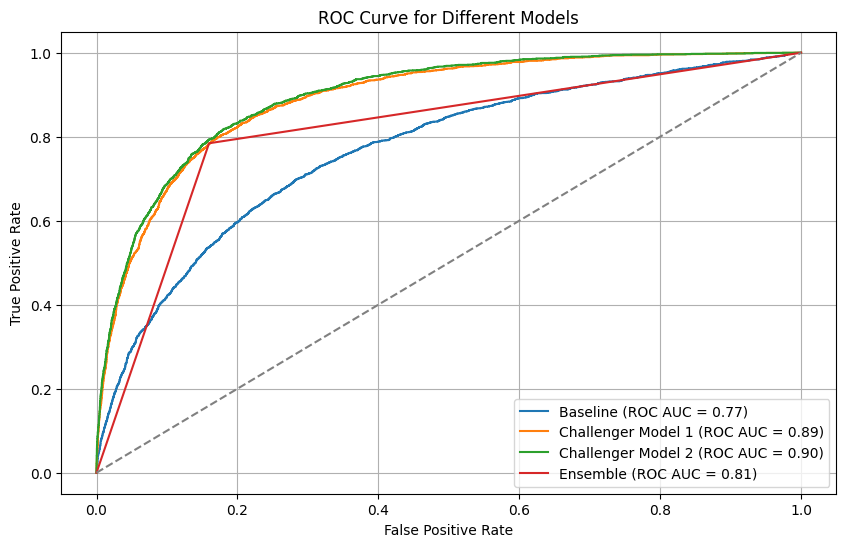

In [24]:
plt.figure(figsize=(10, 6))
for model_name, metrics in evaluation_metrics.items():
    fpr = metrics['fpr']
    tpr = metrics['tpr']
    roc_auc = metrics['ROC AUC']
    plt.plot(fpr, tpr, label=model_name + f' (ROC AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Different Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


## Confusion Matix

Confusion Matrices:


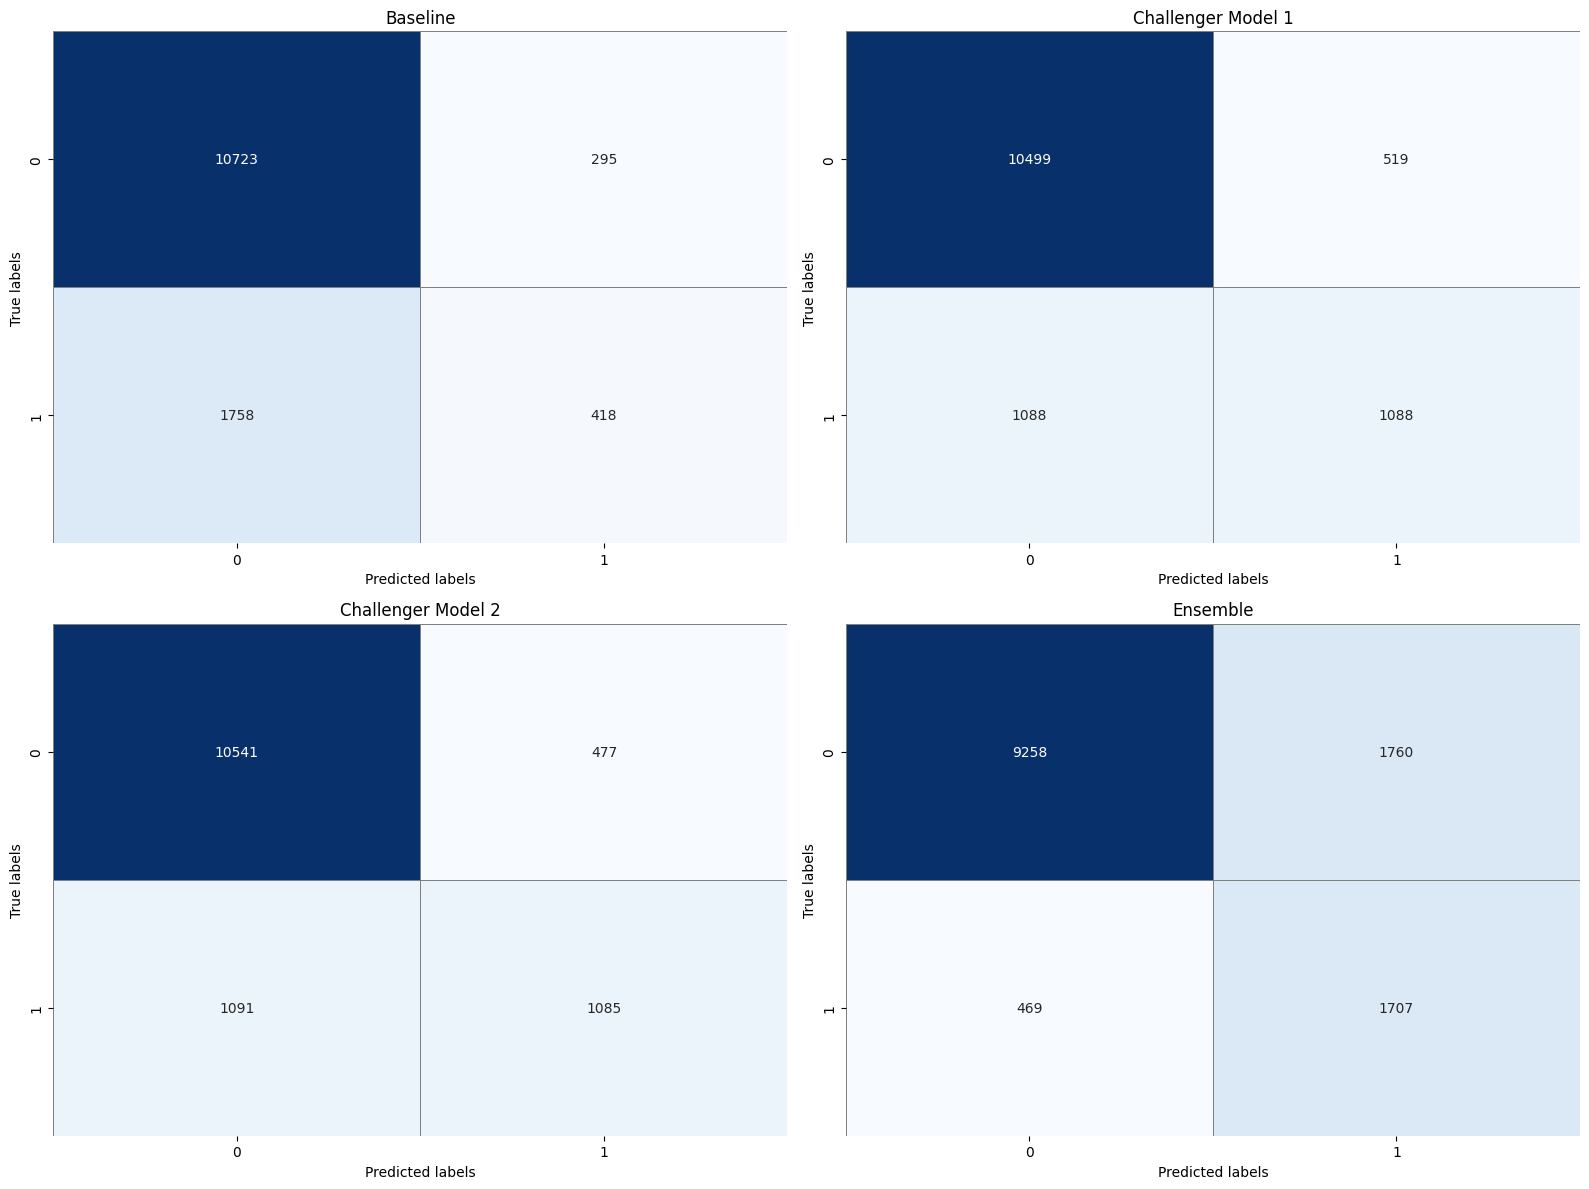

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting confusion matrices for each model
plt.figure(figsize=(16, 12))

# Print each confusion matrix separately
print("Confusion Matrices:")
for i, (model_name, metrics) in enumerate(evaluation_metrics.items(), 1):
    
    plt.subplot(2, 2, i)
    sns.heatmap(metrics['Confusion Matrix'], annot=True, fmt='g', cmap='Blues', cbar=False, linewidths=0.5, linecolor='gray')
    plt.title(model_name)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')

plt.tight_layout()  # Adjust spacing between subplots for better layout
plt.show()


# Conclusion

We have opted for the Ensemble model as our top-performing choice, driven by its higher recall value and F1 score. The ensemble approach, as discussed earlier, utilises a bias correction to maximise recall, albeit potentially decreasing precision. Recall, in the context of fraud detection, signifies the model's proficiency in accurately flagging fraudulent instances, thereby minimising false negatives and capturing fraudulent activities effectively. Conversely, precision denotes the model's precision in identifying fraudulent cases among all predicted positives. 
While both precision and recall hold significance in evaluation, we prioritise recall given the paramount importance of detecting bank fraud w, outweighing the resource costs associated with validating fraud instances.